In [7]:
# House Price Prediction 

# Predict home prices using square footage, bedrooms, age, location, etc


In [2]:
# 1. Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load dataset (adjust path if needed)

df = pd.read_csv("F:\Besant Technlogy\Python\Python Project 2025\house_price_dataset.csv")
df.head()


,House_ID,Area,Bedrooms,Bathrooms,Stories,Parking,Furnishing_Status,Location,Age_of_House,Price
0,H0001,1748,2,2,1,1,Semi-Furnished,Delhi,18,168.64
1,H0002,1430,2,1,1,1,Furnished,Chennai,5,130.05
2,H0003,1823,3,3,1,0,Furnished,Chennai,10,169.04
3,H0004,2261,3,3,1,2,Semi-Furnished,Delhi,28,235.92
4,H0005,1382,1,1,2,2,Semi-Furnished,Hyderabad,10,103.97


In [3]:
# Quick EDA (exploratory data analysis)

In [4]:
# 2. Quick EDA
print(df.info())
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House_ID           1000 non-null   object 
 1   Area               1000 non-null   int64  
 2   Bedrooms           1000 non-null   int64  
 3   Bathrooms          1000 non-null   int64  
 4   Stories            1000 non-null   int64  
 5   Parking            1000 non-null   int64  
 6   Furnishing_Status  1000 non-null   object 
 7   Location           1000 non-null   object 
 8   Age_of_House       1000 non-null   int64  
 9   Price              1000 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB
None
               count        mean         std     min       25%     50%  \
Area          1000.0  1509.16300  489.599001 -120.00  1175.500  1512.5   
Bedrooms      1000.0     2.76800    1.003585    1.00     2.000     3.0   
Bathrooms     1000.0     2.4

In [5]:
# Handle Missing values

print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 House_ID             0
Area                 0
Bedrooms             0
Bathrooms            0
Stories              0
Parking              0
Furnishing_Status    0
Location             0
Age_of_House         0
Price                0
dtype: int64


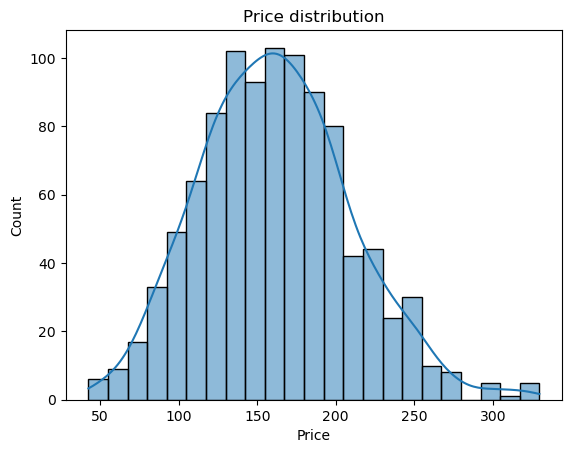

In [6]:
# Distribution of target

sns.histplot(df["Price"], kde=True)
plt.title("Price distribution")
plt.show()


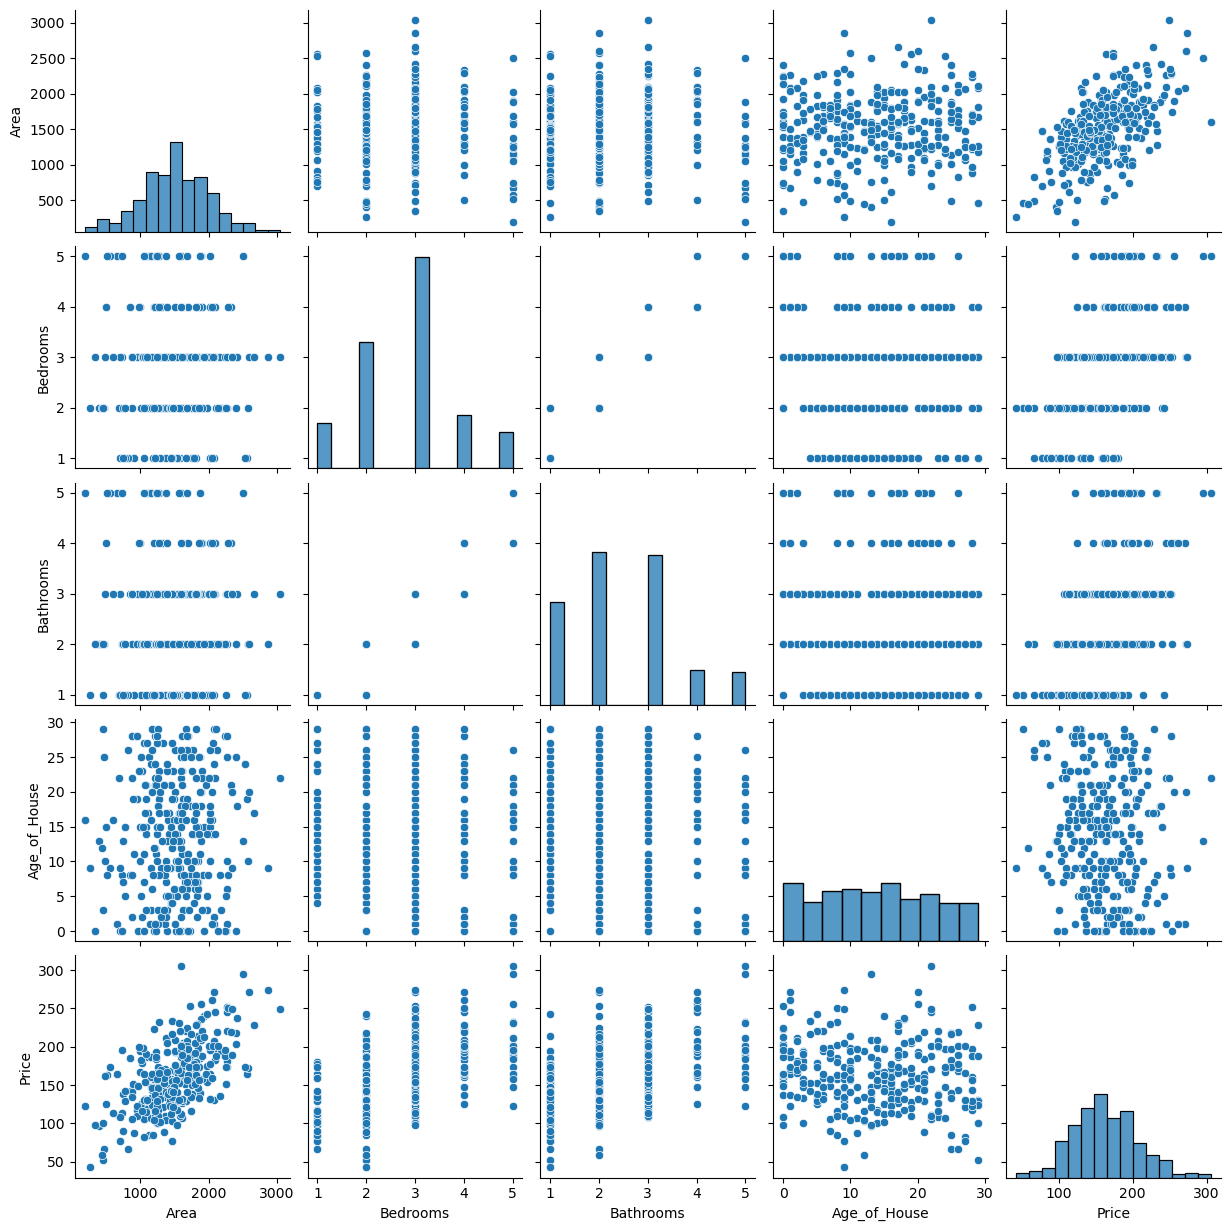

In [7]:
# Pairplot for a few numeric columns (might be slow for many points)

sns.pairplot(df[["Area","Bedrooms","Bathrooms","Age_of_House","Price"]].sample(300))
plt.show()


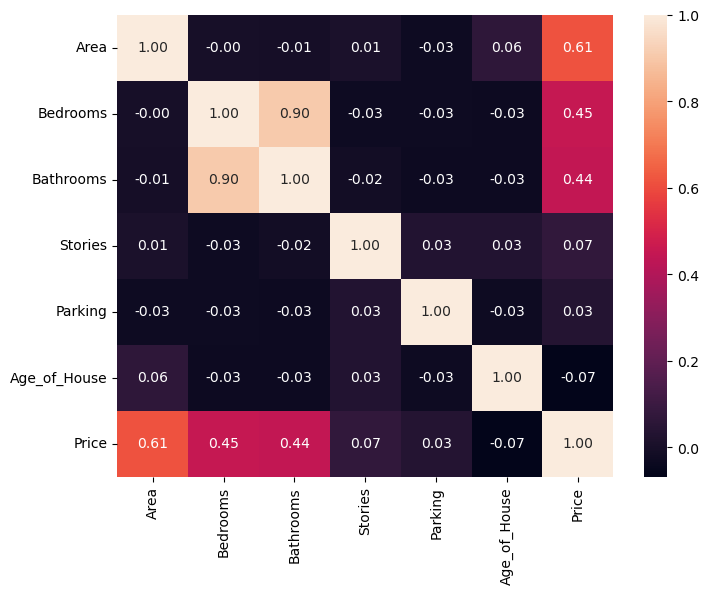

In [17]:
# Correlation heatmap

plt.figure(figsize=(8,6))
sns.heatmap(df[["Area","Bedrooms","Bathrooms","Stories","Parking","Age_of_House","Price"]].corr(), annot=True,  fmt=".2f")
plt.show()

In [17]:
# Preprocessing: choose features & target

# 3. Select features and target
X = df.drop(columns=["House_ID","Price"])  # keep all other columns as features
y = df["Price"]

# Show feature types
print(X.dtypes)


Area                  int64
Bedrooms              int64
Bathrooms             int64
Stories               int64
Parking               int64
Furnishing_Status    object
Location             object
Age_of_House          int64
dtype: object


In [18]:
# Build preprocessing pipeline (encoding + scaling) (Build Predictive Model)

# 4. Preprocessing pipeline
numeric_features = ["Area","Bedrooms","Bathrooms","Stories","Parking","Age_of_House"]
categorical_features = ["Furnishing_Status","Location"]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])


In [19]:
# Train-test split

In [20]:
# 5. Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [21]:
# Baseline: Linear Regression pipeline (Model Evaluation)


In [22]:
# 6. Linear Regression pipeline 
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred = lr_pipeline.predict(X_test)

# Metrics
def reg_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

print("Linear Regression metrics:", reg_metrics(y_test, y_pred))


Linear Regression metrics: {'RMSE': np.float64(14.305110680407518), 'MAE': 11.350372537096252, 'R2': 0.9120380046647167}


In [23]:
# Inspect coefficients (which features matter?)


In [24]:
# 7. Coefficients interpretation

# Get column names after preprocessing

ohe = lr_pipeline.named_steps["preprocessor"].transformers_[1][1].named_steps["onehot"]
ohe_cols = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_cols)

coefs = lr_pipeline.named_steps["regressor"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coefs})
coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)
print(coef_df)


                             feature  coefficient
11                  Location_Kolkata   -42.118052
12                   Location_Mumbai    32.262252
0                               Area    30.496213
7      Furnishing_Status_Unfurnished   -28.819380
8                   Location_Chennai   -26.177704
13                     Location_Pune   -19.511928
9                     Location_Delhi    15.791584
6   Furnishing_Status_Semi-Furnished   -14.040808
10                Location_Hyderabad   -13.493027
1                           Bedrooms    13.196774
2                          Bathrooms    10.731299
5                       Age_of_House    -5.342643
3                            Stories     4.572746
4                            Parking     2.932043


In [25]:
# Residuals & diagnostics

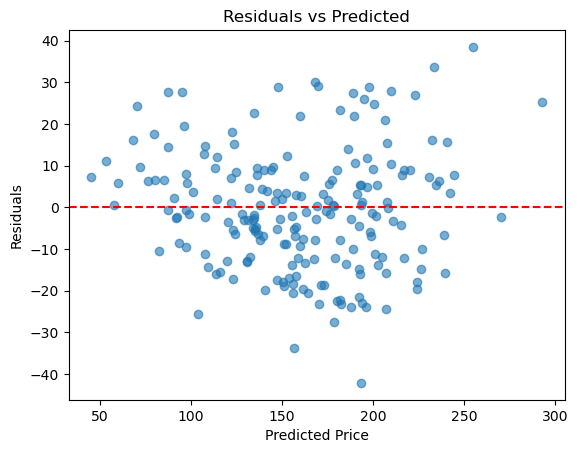

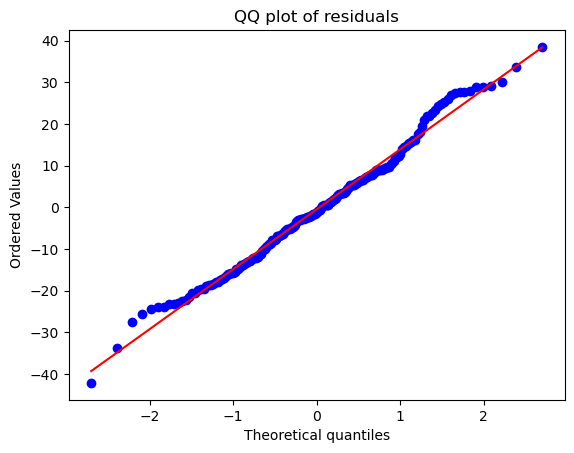

In [26]:
# 8. Residuals
residuals = y_test - y_pred

# Residual plot
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# QQ-plot for residual normality
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ plot of residuals")
plt.show()


In [27]:
# Cross-validation

In [28]:
# 9. Cross-validation (5-fold)
cv_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring="r2")
print("CV R2 scores:", cv_scores)
print("CV R2 mean:", cv_scores.mean())


CV R2 scores: [0.91490855 0.89739087 0.9149885  0.91121417 0.89341258]
CV R2 mean: 0.9063829364659604


In [29]:
# Regularization: Ridge & Lasso (prevents overfitting / handles multicollinearity)

In [30]:
# 10. Ridge & Lasso with simple GridSearch
pipeline_ridge = Pipeline([
    ("preprocessor", preprocessor),
    ("reg", Ridge())
])
pipeline_lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("reg", Lasso(max_iter=5000))
])

# Search alphas
param_grid = {"reg__alpha":[0.1,1,10,50,100]}

ridge_gs = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring="r2")
lasso_gs = GridSearchCV(pipeline_lasso, param_grid, cv=5, scoring="r2")

ridge_gs.fit(X_train, y_train)
lasso_gs.fit(X_train, y_train)

print("Best Ridge alpha:", ridge_gs.best_params_, "R2:", ridge_gs.best_score_)
print("Best Lasso alpha:", lasso_gs.best_params_, "R2:", lasso_gs.best_score_)

# Evaluate on test
for name, model in [("Ridge", ridge_gs.best_estimator_), ("Lasso", lasso_gs.best_estimator_)]:
    y_pred_m = model.predict(X_test)
    print(name, reg_metrics(y_test, y_pred_m))


Best Ridge alpha: {'reg__alpha': 0.1} R2: 0.902306706463016
Best Lasso alpha: {'reg__alpha': 0.1} R2: 0.9017564346466242
Ridge {'RMSE': np.float64(14.307253789603841), 'MAE': 11.353206233524554, 'R2': 0.9120116467725977}
Lasso {'RMSE': np.float64(14.440767890322684), 'MAE': 11.513542596686163, 'R2': 0.9103617843683349}


In [31]:
# (Optional) OLS with statsmodels — get p-values

In [32]:
# 11. OLS with statsmodels for p-values (requires building design matrix manually)
import statsmodels.api as sm

# Preprocess X to a numeric array (fit preprocessor on full data or train set)
X_processed = preprocessor.fit_transform(X)  # or transform(X_train) if preferred

# Add constant for intercept
X_sm = sm.add_constant(X_processed)
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     705.6
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:52:39   Log-Likelihood:                -4084.6
No. Observations:                1000   AIC:                             8199.
Df Residuals:                     985   BIC:                             8273.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        181.5145      1.329    136.538      0.0

In [33]:
# Feature engineering ideas (if model underperforms)

In [34]:
# Example: transform target to log if skewed
y_log = np.log1p(y)  # use log1p to handle zeros
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

pipeline_log = Pipeline([("preprocessor", preprocessor), ("reg", LinearRegression())])
pipeline_log.fit(X_train, y_train_log)
y_pred_log = pipeline_log.predict(X_test)
# Convert back
y_pred_back = np.expm1(y_pred_log)
y_test_back = np.expm1(y_test_log)
print("Metrics after log transform:", reg_metrics(y_test_back, y_pred_back))


Metrics after log transform: {'RMSE': np.float64(14.903895825651087), 'MAE': 11.5699625625377, 'R2': 0.9045200373907301}


In [35]:
# Save your final model

In [36]:
# 13. Save model with joblib
import joblib
final_model = ridge_gs.best_estimator_  # or whichever model you choose
final_model.fit(X, y)  # retrain on full data
joblib.dump(final_model, "house_price_model.pkl")
# Load later:
# model = joblib.load("house_price_model.pkl")


['house_price_model.pkl']